# Tutorial 2: Clustering and Manifold Learning

This notebook demonstrates:
- the k-Means clustering algorithm
- the use of manifold-learning techniques to project a clustered dataset into a 2D space and visualise it as a scatterplot

In this tutorial, we use the well-known __iris__ dataset (see https://archive.ics.uci.edu/dataset/53/iris) with the labels removed. This dataset contains the dimensions and the species (the label) of 150 iris flowers. The goal of this tutorial is to find a clustering of the dataset when the label is removed and see if the 150 iris flowers naturally fall into separate groups/clusters. A secondary goal is to use manifold learning techniques for visualising the clustering in 2D.

When you go through this notebook for the first time you may __skip section C__ and go back to it at the end.

### A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

#### Load the dataset

In [2]:
df = pd.read_csv("./iris_nolabels.csv")
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (150, 4)


### B. Exploratory Data Analysis and Data Preparation

In [3]:
df.head()

,sepallength,sepalwidth,petallength,petalwidth
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
df.tail()

,sepallength,sepalwidth,petallength,petalwidth
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3
149,5.9,3.0,5.1,1.8


In [5]:
df.describe()

,sepallength,sepalwidth,petallength,petalwidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


The dataset consists of 150 data rows and 4 numerical columns, which represent the dimensions of iris flowers. There are no missing values. In the original dataset, each data row is labelled. The label is the species, and there are three species in the dataset: iris setosa, iris versicolor and iris virginica.

Let's check the distribution of the numerical attributes.

array([[<Axes: title={'center': 'sepallength'}>,
        <Axes: title={'center': 'sepalwidth'}>],
       [<Axes: title={'center': 'petallength'}>,
        <Axes: title={'center': 'petalwidth'}>]], dtype=object)

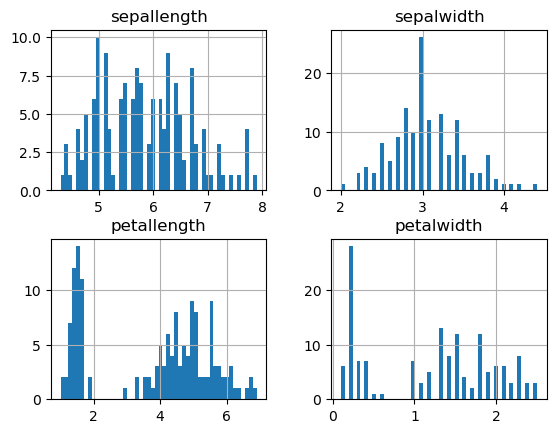

In [6]:
df.hist(bins=50)

<Axes: >

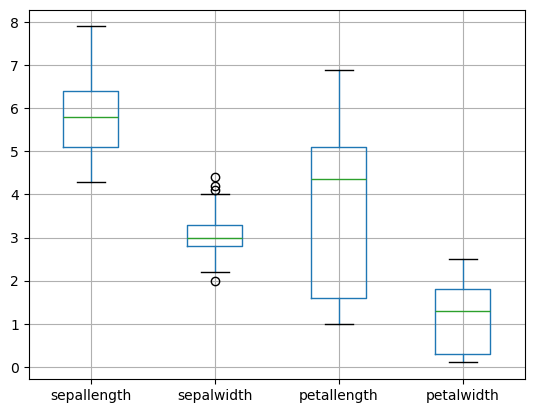

In [7]:
df.boxplot()

In general, clustering algorithms benefit from standardising the data. In this case, we can apply MinMaxScaler or StandardScaler to the three columns without outliers and RobustScaler to petallength. We can also apply log transformation to petallength and petalwidth which appear skewed to the left. 

We will do this by constructing a scikit-learn pipeline for data preparation (preprocess_pipeline). Pipelines make it easier to explore various options for the data preparation step and tune hyperparameters. In this e-tivity we will only use a pipeline as a more structured approach to data preparation. We will see how pipelines can be used for hyperparameter tuning in e-tivity 3.

In [8]:
# First, we define a pipeline consisting of two transforms, applied to the petallength and petalwidth columns in a sequence.
petal_pipeline = Pipeline(
    steps = [
        ("distribution_transform", FunctionTransformer(func=np.log)), 
        ("scaler", MinMaxScaler())
    ]
)

# Next, we use ColumnTransformer to construct the main preprocessing pipeline which consists of all data preprocessing steps applied to all columns.
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("sepallength", StandardScaler(), ['sepallength']),    # preprocessing of sepallength
        ("sepalwidth", RobustScaler(), ['sepalwidth'])         # preprocessing of sepalwidth
    ],
    remainder = petal_pipeline # applied to 'petallength' and 'petalwidth'
)

### C. Scatterplot Function (to be used below for visualising a clustering)

Skip this section when you read the notebook for the first time.

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [9]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### D. K-Means Clustering

The k-Means clustering algorithm has the number of clusters $k$ as an input parameter __n_clusters__. We construct a final pipeline for training a k-Means clustering model for a fixed value of __n_clusters__ $=3$. The final pipeline has the preprocessing pipeline as its first step followed by the scikit-learn KMeans algorithm as a second step.

In [10]:
k = 3

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

Next, we fit the pipeline on the dataset to train a clustering model.

In [11]:
clustering_model = pipe.fit(df)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [12]:
# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)
preprocessed_data

array([[-0.90068117,  1.        ,  0.17420062,  0.21533828],
       [-1.14301691,  0.        ,  0.17420062,  0.21533828],
       [-1.38535265,  0.4       ,  0.13583296,  0.21533828],
       [-1.50652052,  0.2       ,  0.20992007,  0.21533828],
       [-1.02184904,  1.2       ,  0.17420062,  0.21533828],
       [-0.53717756,  1.8       ,  0.27472036,  0.43067656],
       [-1.50652052,  0.8       ,  0.17420062,  0.3413031 ],
       [-1.02184904,  0.8       ,  0.20992007,  0.21533828],
       [-1.74885626, -0.2       ,  0.17420062,  0.21533828],
       [-1.14301691,  0.2       ,  0.20992007,  0.        ],
       [-0.53717756,  1.4       ,  0.20992007,  0.21533828],
       [-1.26418478,  0.8       ,  0.24333338,  0.21533828],
       [-1.26418478,  0.        ,  0.17420062,  0.        ],
       [-1.87002413,  0.        ,  0.04934461,  0.        ],
       [-0.05250608,  2.        ,  0.09439272,  0.21533828],
       [-0.17367395,  2.8       ,  0.20992007,  0.43067656],
       [-0.53717756,  1.

### E. Apply a manifold-learning technique to project the data set to a 2D space

https://scikit-learn.org/stable/modules/manifold.html

Append the cluster centers to the preprocessed dataset.

In [13]:
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

#### E1. Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [14]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")

transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

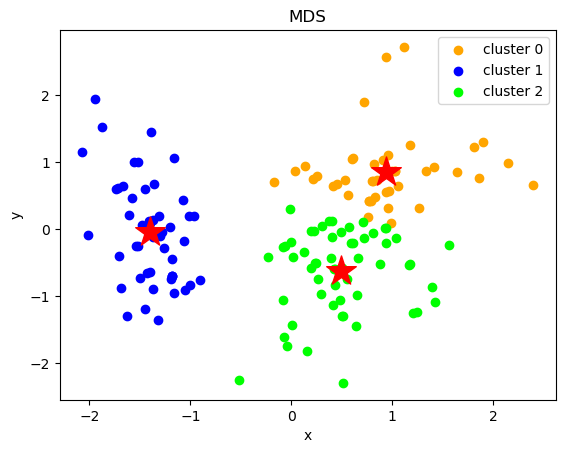

In [15]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [16]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

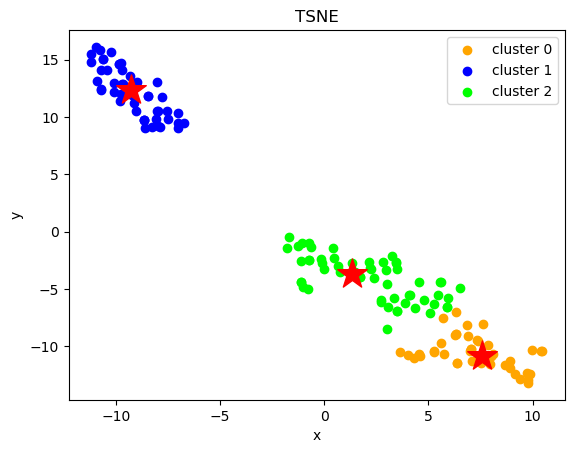

In [17]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### F. Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [18]:
df['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)

In [19]:
df.head()

,sepallength,sepalwidth,petallength,petalwidth,cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [20]:
df.tail()

,sepallength,sepalwidth,petallength,petalwidth,cluster
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0
149,5.9,3.0,5.1,1.8,2


#### Compute the mean value of each attribute for each cluster

In [21]:
df.groupby('cluster').mean()

,sepallength,sepalwidth,petallength,petalwidth
cluster,,,,
0,6.837209,3.120930,5.462791,1.939535
1,5.016327,3.440816,1.467347,0.242857
2,5.805172,2.677586,4.431034,1.456897


#### Conclusion

By looking at the table above we can argue that:
* Cluster 0 are large iris flowers with the largest petals out of the three types.
* Cluster 1 are iris flowers with small petals (notably smaller than the other two types) but with wide sepals, the widest sepals of all three types. This is also the cluster that is clearly differentiated from the other two clusters in the scatter plots.
* Cluster 2 flowers are slightly smaller than cluster 0 flowers with a most notable difference in the width of the petals.

_Note that this conclusion is true for this run of k-Means. If the code is executed again, k-Means may produce either different clusters or the same clusters but in a different order._